## Introduction

In [1]:
import RMT

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/import/silo3/wardak/.venv/lib64/python3.9/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [18]:
torchvision.datasets.CIFAR100(root="fig/datasets", download=True)

100%|██████████| 169M/169M [00:11<00:00, 14.2MB/s] 
/usr/lib64/python3.9/tarfile.py:2288: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  warnings.warn(


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: fig/datasets
    Split: Train

In [56]:
norm_data.shape

(50000, 3072)

In [35]:
dataset = torchvision.datasets.CIFAR10(root="fig/datasets", transform=torchvision.transforms.ToTensor())
dataset_data = np.array(dataset.data, dtype=np.float32)
dataset_targets = np.array(dataset.targets)
display(dataset.data.shape)
class_to_data = {name: dataset_data[dataset_targets == l] for name, l in dataset.class_to_idx.items()}
# show number of images (and tensor shape) per class
display({k: v.shape for k, v in class_to_data.items()})
layer_size = np.prod(dataset.data.shape[1:])
display(layer_size)
norm_data_dict = {
    k: (v / np.mean(v**2, tuple(range(1, len(v.shape))), keepdims=True)**0.5)
    for k, v in class_to_data.items()
}

(50000, 32, 32, 3)

{'airplane': (5000, 32, 32, 3),
 'automobile': (5000, 32, 32, 3),
 'bird': (5000, 32, 32, 3),
 'cat': (5000, 32, 32, 3),
 'deer': (5000, 32, 32, 3),
 'dog': (5000, 32, 32, 3),
 'frog': (5000, 32, 32, 3),
 'horse': (5000, 32, 32, 3),
 'ship': (5000, 32, 32, 3),
 'truck': (5000, 32, 32, 3)}

3072

## Demonstration on empirical MLPs

In [ ]:
outputs_dict = {}

alpha = 1.5
sigma_W = 1.5

fp_norm = (
    RMT.MFT_map(RMT.q_star_MC(alpha, sigma_W)[-1], alpha, sigma_W, usetqdm=False)[
        "postact_sq_mean"
    ][0]
    ** 0.5
)

for label, data in tqdm(norm_data_dict.items()):
    num_items = 2 # len(data)
    # flatten the images and scale by fixed point norm
    x0 = data[:num_items].reshape(num_items, -1) * fp_norm
    xs = RMT.MLP(
        torch.tensor(x0),
        10,
        alpha,
        sigma_W,
        seed=42,
        fast=True,
        usetqdm=False,
    )["postact"]
    norms = (np.array([x0, *xs]) ** 2).mean(-1) ** 0.5

    outputs_dict[label] = norms

In [ ]:
color_dict = {label: plt.cm.tab10(i) for i, label in enumerate(norm_data_dict.keys())}
for label, norms in outputs_dict.items():
    plt.plot(
        norms.mean(-1),
        "-o",
        # alpha=x0.shape[0] ** -0.5,
        color=color_dict[label],
        label=label,
    )
    plt.fill_between(
        np.arange(len(norms)),
        np.quantile(norms, 0.01, axis=-1),
        np.quantile(norms, 0.99, axis=-1),
        color=color_dict[label],
        alpha=0.5,
    )

plt.ylim([0.25, 0.75])
# plt.legend()
plt.show()

## MFT demonstration
takes longer than the MLP (about 7m33s on a Tesla M4 for CIFAR-10, 10 layers)

In [ ]:
outputs_dict = {}

alpha = 1.5
sigma_W = 1.5

fp_norm = (
    RMT.MFT_map(RMT.q_star_MC(alpha, sigma_W)[-1], alpha, sigma_W, usetqdm=False)[
        "postact_sq_mean"
    ][0]
    ** 0.5
)

# gpu memory bottleneck due to `RMT.MFT_map::postact_samples`
max_num_items_in_batch = 100

for label, data in tqdm(norm_data_dict.items()):
    num_items = 100  # len(data)
    x0 = data[:num_items].reshape(num_items, -1) * fp_norm
    q0 = sigma_W**alpha * (abs(x0) ** alpha).mean(-1)
    MFT_maps = []
    for q0_chunk in tqdm(
        np.array_split(q0, max(1, num_items // max_num_items_in_batch), axis=0),
        leave=False,
    ):
        torch.manual_seed(42)
        val = RMT.MFT_map(
            q0_chunk,
            alpha,
            sigma_W,
            num_layers=10,
            agg_postact=lambda x: {
                "sq_mean": (x**2).mean(-1),
                "alpha_mean": (abs(x) ** alpha).mean(-1),
            },
            usetqdm=False,
        )
        MFT_maps.append(val)
    # average over Monte-Carlo realisations (axis=2), then concatenate chunks of inputs (axis=1)
    agg_stats = {
        k: np.concatenate([np.mean(mft[k], axis=2) for mft in MFT_maps], axis=1)
        for k in MFT_maps[0]
    }
    norms = np.array([(x0**2).mean(-1), *agg_stats["postact_sq_mean"]]) ** 0.5
    alpha_norms = np.array(
        [(abs(x0) ** alpha).mean(-1), *agg_stats["postact_alpha_mean"]]
    ) ** (1 / alpha)
    qs = agg_stats["q_val"]

    outputs_dict[label] = norms

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
def MFT_map(
    dataset_name, alpha, sigma_W, sigma_b=0.0, num_layers=10, chunk_size=100, seed=42
):
    if dataset_name == "CIFAR10":
        dataset = torchvision.datasets.CIFAR10(
            root="fig/datasets", transform=torchvision.transforms.ToTensor()
        )
    elif dataset_name == "MNIST":
        dataset = torchvision.datasets.MNIST(
            root="fig/datasets", transform=torchvision.transforms.ToTensor()
        )
    else:
        raise ValueError(f"Dataset {dataset_name} not implemented.")
    dataset_data = np.array(dataset.data, dtype=np.float32)
    flattened_data = dataset_data.reshape(len(dataset_data), -1)
    normed_data = (
        flattened_data / np.mean(flattened_data**2, axis=1, keepdims=True) ** 0.5
    )
    fp_norm = (
        RMT.MFT_map(RMT.q_star_MC(alpha, sigma_W)[-1], alpha, sigma_W, usetqdm=False)[
            "postact_sq_mean"
        ][0]
        ** 0.5
    )
    x0 = normed_data.reshape(len(normed_data), -1) * fp_norm
    q0 = sigma_W**alpha * (abs(x0) ** alpha).mean(-1) + sigma_b**alpha
    MFT_maps = []
    for q0_chunk in tqdm(np.array_split(q0, chunk_size, axis=0)):
        torch.manual_seed(seed)
        MFT_maps.append(
            RMT.MFT_map(
                q0_chunk,
                alpha,
                sigma_W,
                sigma_b=sigma_b,
                num_layers=num_layers,
                agg_postact=lambda x: {
                    "sq_mean": (x**2).mean(-1),
                    "alpha_mean": (abs(x) ** alpha).mean(-1),
                },
                usetqdm=False,
            )
        )
    # average over Monte-Carlo realisations (axis=2), then concatenate chunks of inputs (axis=1)
    agg_stats = {
        k: np.concatenate([np.mean(mft[k], axis=2) for mft in MFT_maps], axis=1)
        for k in MFT_maps[0]
    }
    return agg_stats

In [58]:
MFT_map(
    dataset_name="CIFAR10",
    alpha=1.5,
    sigma_W=1.5,
    sigma_b=0.0,
    num_layers=10,
    chunk_size=100,
    seed=42,
)

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.86 GiB. GPU 0 has a total capacity of 3.69 GiB of which 1.36 GiB is free. Including non-PyTorch memory, this process has 2.33 GiB memory in use. Of the allocated memory 2.26 GiB is allocated by PyTorch, and 18.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [42]:
{k: v.shape for k, v in agg_stats.items()}

{'postact_sq_mean': (10, 100),
 'postact_alpha_mean': (10, 100),
 'q_val': (10, 100)}

In [ ]:
# np.savez('fig/mixed_selectivity/outputs_MLP.npz', **outputs_dict)
outputs_dict = np.load('fig/mixed_selectivity/outputs_MLP.npz')

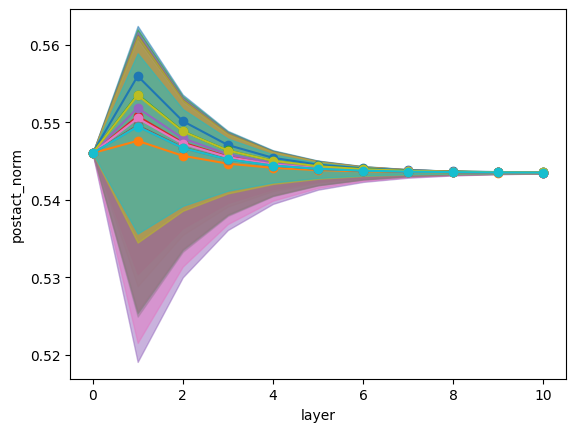

In [41]:
fig, ax = plt.subplots()

color_dict = {label: plt.cm.tab10(i) for i, label in enumerate(norm_data_dict.keys())}
for label, norms in outputs_dict.items():
    ax.plot(
        norms.mean(-1),
        "-o",
        # alpha=x0.shape[0] ** -0.5,
        color=color_dict[label],
        label=label,
    )
    ax.fill_between(
        np.arange(len(norms)),
        np.quantile(norms, 0.01, axis=-1),
        np.quantile(norms, 0.99, axis=-1),
        color=color_dict[label],
        alpha=0.5,
    )

ax.set(
    xlabel='layer',
    ylabel='postact_norm',
    # ylim=(0.25, 0.75),
)
# ax.legend()
plt.show()